processing 0 krass
processing 0 gaffen
processing 0 unglaubwuerdig
processing 0 freude
processing 0 sauber


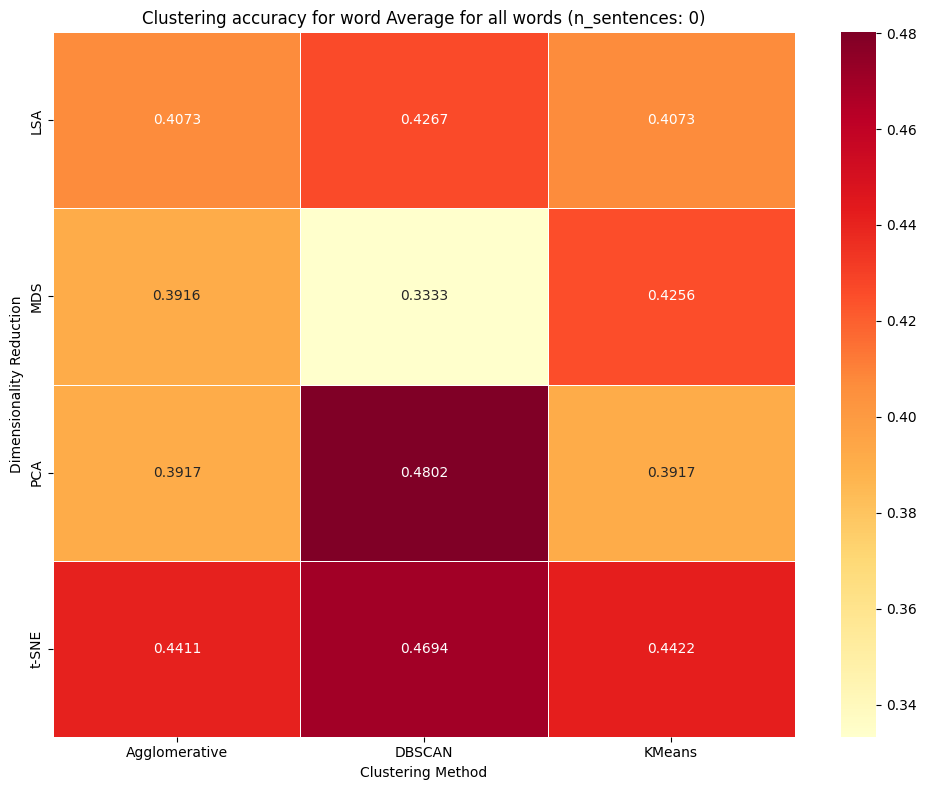

processing 100 krass
processing 100 gaffen
processing 100 unglaubwuerdig
processing 100 freude
processing 100 sauber


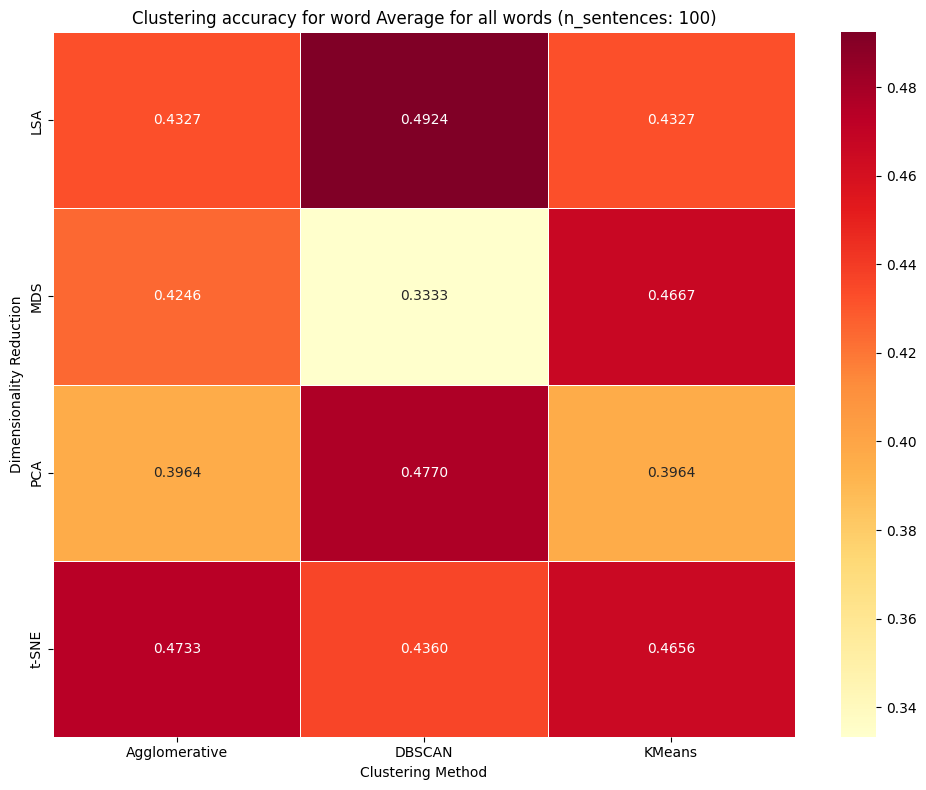

processing 1000 krass
processing 1000 gaffen
processing 1000 unglaubwuerdig
processing 1000 freude
processing 1000 sauber


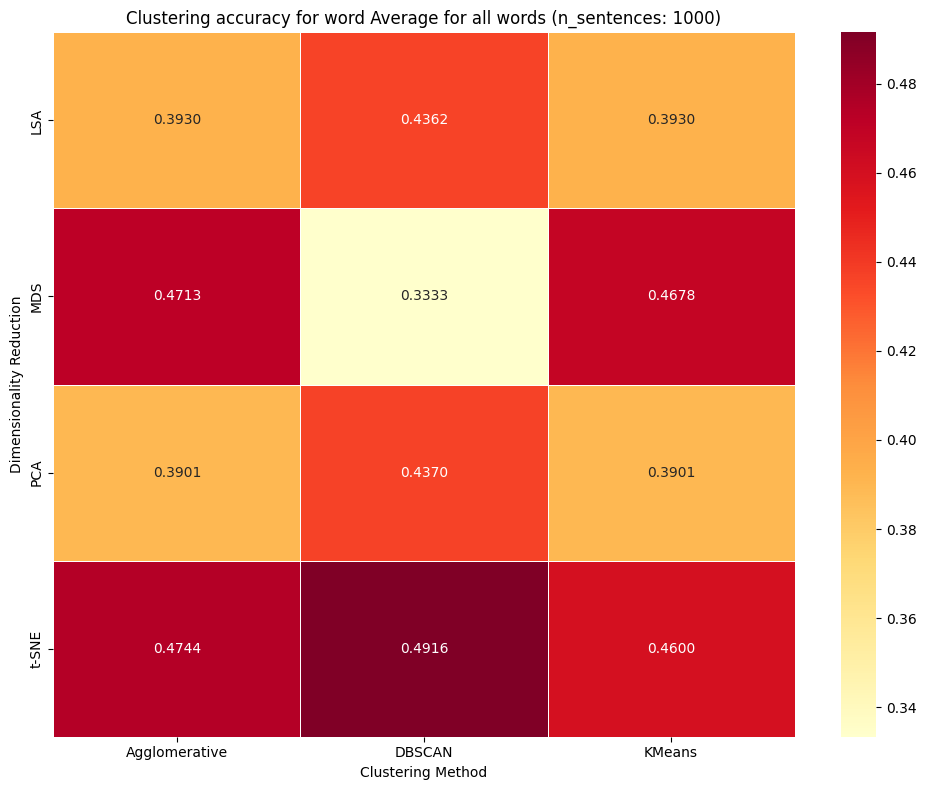

processing 5000 krass
processing 5000 gaffen
processing 5000 unglaubwuerdig
processing 5000 freude
processing 5000 sauber


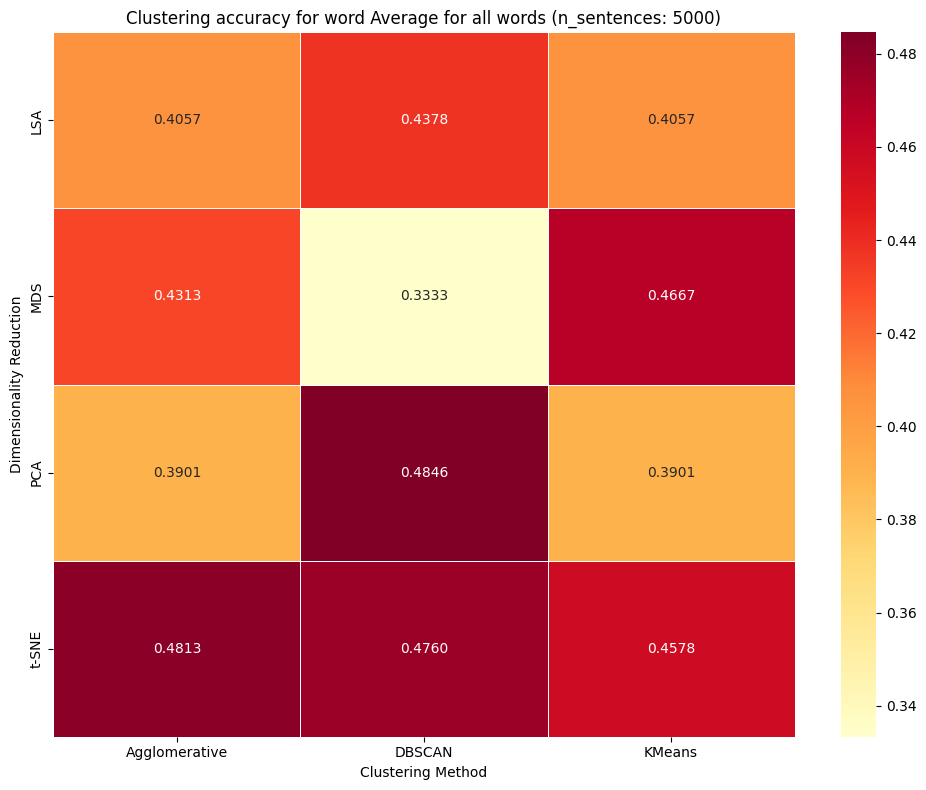

In [1]:
import numpy as np
from collections import defaultdict
from melon_clustering import PatternExtractorOneHot, ClusterEvaluator, ClusterManager, Loader, reference_clusters_de

dim_reduction_methods = ['LSA', 'PCA', 't-SNE', 'MDS']
clustering_methods = ['KMeans', 'Agglomerative', 'DBSCAN']
cluster_manager = ClusterManager()

for n_sentences in [0, 100, 1000, 5000]:
    all_results_dfs = []
    for ref_word, reference_clusters in reference_clusters_de.items():
        print("processing", n_sentences, ref_word)
        additional_sentences_dict = Loader.load_sentences_from_word(ref_word, 'de', n_sentences=n_sentences)
        evaluator = ClusterEvaluator(reference_clusters=reference_clusters)
        sentences_dict_ref = evaluator.add_reference_sentences(reference_clusters)
        sentences_dict_db = evaluator.add_additional_sentences(additional_sentences_dict)
        extractor = PatternExtractorOneHot(language='de', filter_threshold=1)

        combined_sentences_dict = defaultdict(list)
        for word, sentences in sentences_dict_ref.items():
            combined_sentences_dict[word].extend(sentences)
        for word, sentences in sentences_dict_db.items():
            combined_sentences_dict[word].extend(sentences)

        extractor.extract_patterns_flat(combined_sentences_dict, min_occurrences=1)
        sentence_pattern_mapping = extractor.map_sentences_to_patterns(combined_sentences_dict)
        one_hot_vectors = extractor.generate_embeddings(sentence_pattern_mapping)
        print("one_hot_vectors",one_hot_vectors)
        vectors_reference = evaluator.isolate_reference_embeddings(one_hot_vectors, num_additional_sentences=len(sentences_dict_db['krass']))
        print("vectors_reference",vectors_reference)
        reference_sentence_ids = sorted(evaluator.reference_sentence_ids)
        reference_sentence_paths = [(sid, evaluator.sentence_id_to_original[sid]) for sid in reference_sentence_ids]

        clustering_results = cluster_manager.run_all_configurations(
            vectors=vectors_reference,
            dim_methods=dim_reduction_methods,
            cluster_methods=clustering_methods,
            sentence_paths=reference_sentence_paths,
            plot_seaborn=False,
            plot_plt=False,
            annotate_plt=True
        )

        results_df = evaluator.evaluate_multiple_configurations(clustering_results, ref_word, plot = False)
        all_results_dfs.append(results_df)

    if all_results_dfs:
        evaluator.plot_average_similarity_heatmap(all_results_dfs, 'Average for all words', n_sentences=str(n_sentences))
